In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.cluster import KMeans
from sdv.single_table import GaussianCopulaSynthesizer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
from scipy.stats import norm

Matplotlib is building the font cache; this may take a moment.


# 1. Data cleaning

In [2]:
original = pd.read_csv("../data/BankChurners.csv")
balance_df = pd.read_csv("../data/botswana_bank_customer_churn.csv")
technical_df = pd.read_csv("../data/User churn.csv")

In [3]:
# removing irrelevent columns
original = original.drop(original.columns[[-1, -2]], axis=1)
original = original.drop(columns=['Avg_Open_To_Buy','Total_Amt_Chng_Q4_Q1','Contacts_Count_12_mon','Total_Ct_Chng_Q4_Q1'])

# renaming the datasets
original = original.rename(columns={'Months_on_book' : 'Month_with_bank',
                                    'Total_Relationship_Count' : 'No_of_product',
                                    'Total_Trans_Ct' : 'Total_Trans_Count'})

# removing Na from the dataset
original_Unknown = original[original.isin(['Unknown']).any(axis=1)] # someone handle the unknown please
original = original[~original.isin(['Unknown']).any(axis=1)]


In [4]:
# this function will remove the k,$ and + sign in the income category column
def clean_col(x):
        if 'K' in x:
            return x.replace('K','').replace('$','')
        elif '+' in x:
            return x.replace('+','')
        elif x =='Less than 40':
            return x.split()[2]
        return x
    
original['Income_Category']=original['Income_Category'].apply(clean_col)

In [5]:
# Converting object into category
categorical_features = ['Attrition_Flag','Gender','Education_Level','Marital_Status','Income_Category','Card_Category']
for category in categorical_features:
    original[category] = original[category].astype('category')

# 2. Synthetic data 

## 2.1 Balance dataset

Adding in  `Credit Score`,`Outstanding Loans`, `Balance` from balance dataset. The final dataframe is stored as `final_df`

### 2.1.1 Feature selection

In [6]:
# subsetting from the original data
required_features = ["CLIENTNUM","Customer_Age","Gender","Income_Category","No_of_product"]
subset_original = original.loc[:,required_features]

# subsetting from the income data
required_features2 = ['Date of Birth','Gender','Income','NumOfProducts','Credit Score','Outstanding Loans', 'Balance']
subset_balance = balance_df.loc[:,required_features2]

### 2.1.2 Data Cleaning

In [7]:
# Changing date of birth to date time and them convert it to age
subset_balance['Date of Birth'] = pd.to_datetime(subset_balance['Date of Birth'])
reference_date = pd.Timestamp('2024-01-01')
subset_balance['Date of Birth'] = reference_date.year - subset_balance['Date of Birth'].dt.year

# Changing income into income category
bins = [0, 40000, 60000, 80000, 120000, float('inf')]
labels = ['Less than 40', '40 - 60', '60 - 80', '80 - 120', '120 +']
subset_balance['Income'] = pd.cut(subset_balance['Income'], bins=bins, labels=labels, right=False)

# Recoding Male to M...
subset_balance['Gender'] = subset_balance['Gender'].replace({'Male':'M','Female':'F'})

# Renaming the balance_subset dataframe
subset_balance = subset_balance.rename(columns = {'Date of Birth' : "Customer_Age", 
                                        'Income' : "Income_Category", 'NumOfProducts' : "No_of_product"})

# Converting object to category
subset_balance['Gender'] = subset_balance['Gender'].astype('category')

### 2.1.3 Data Transformation

In [8]:
#Scaling 
scaler = MinMaxScaler()
subset_balance[['Customer_Age','No_of_product']] = scaler.fit_transform(subset_balance[['Customer_Age','No_of_product']])
subset_original[['Customer_Age','No_of_product']] = scaler.fit_transform(subset_original[['Customer_Age','No_of_product']])

# Encode the categorical variables
le_gender = LabelEncoder()
subset_balance['Gender_Encoded'] = le_gender.fit_transform(subset_balance['Gender'])
subset_original['Gender_Encoded'] = le_gender.fit_transform(subset_original['Gender'])

le_income = LabelEncoder()
subset_balance['Income_Category_Encoded'] = le_income.fit_transform(subset_balance['Income_Category'])
subset_original['Income_Category_Encoded'] = le_income.fit_transform(subset_original['Income_Category'])

# Extract relevant features for clustering
features_balance = subset_balance[['Customer_Age', 'No_of_product', 'Gender_Encoded', 'Income_Category_Encoded']]
features_original = subset_original[['Customer_Age', 'No_of_product', 'Gender_Encoded', 'Income_Category_Encoded']]

### 2.1.4 Model Training

In [9]:
# Perform KMeans clustering on balance data and find optimal clusters
cluster_range = range(2, 7)  # Define the range of cluster numbers to test
inertia_values = []  # Inertia will help determine the optimal cluster number

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_balance)
    inertia_values.append(kmeans.inertia_)

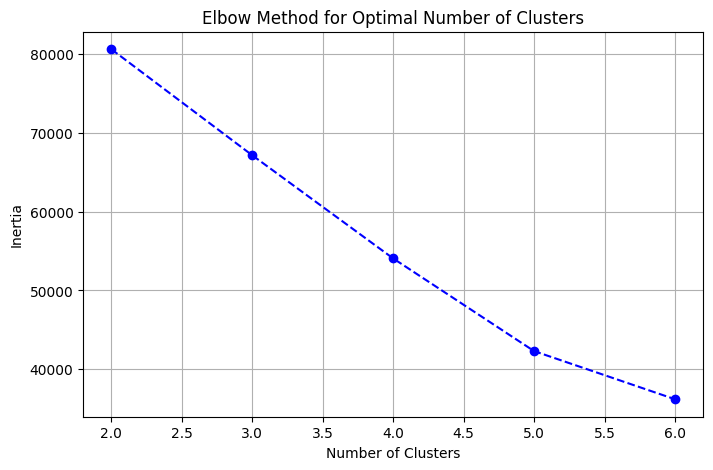

In [10]:
# Plot the elbow method to determine the best cluster count
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia_values, marker='o', linestyle='--', color='b')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [11]:
# Fit the final KMeans model with the selected number of clusters
optimal_k = 5  # Choosen based on the elbow plot
kmeans_final = KMeans(n_clusters=optimal_k, random_state=3101)
kmeans_final.fit(features_balance)
subset_balance['Cluster_Labels'] = kmeans_final.labels_

#Predict cluster labels for the original subset using the same KMeans model
subset_original['Cluster_Labels'] = kmeans_final.predict(features_original)

In [12]:
# List of target variables
target_columns = ['Credit Score','Outstanding Loans', 'Balance']

# Dictionary to hold fitted parameters (mean, std) for each cluster and each target variable
cluster_params = {}

for target in target_columns:
    cluster_params[target] = {}
    # Group by clusters
    for cluster in subset_balance['Cluster_Labels'].unique():
        cluster_data = subset_balance[subset_balance['Cluster_Labels'] == cluster][target]
        # Fit a normal distribution to the data in the cluster
        mean, std = norm.fit(cluster_data)
        cluster_params[target][cluster] = (mean, std)

In [13]:
# Create a function to draw samples based on the cluster label using CLIENTNUM
def generate_synthetic_data_with_clientnum(base_data, cluster_params, target):
    # Initialize a dictionary for storing CLIENTNUM and synthetic values
    synthetic_values = {}
    
    # Iterate over each record in the base data
    for idx, row in base_data.iterrows():
        clientnum = row['CLIENTNUM']  # Fetch the unique identifier
        cluster_label = row['Cluster_Labels']  # Assuming cluster labels are already assigned to base data
        mean, std = cluster_params[target][cluster_label]
        
        # Draw a sample from the normal distribution
        synthetic_value = norm.rvs(loc=mean, scale=std)
        
        # Store the synthetic value with CLIENTNUM as the key
        synthetic_values[clientnum] = synthetic_value
    
    return synthetic_values

# Generate synthetic data for each target variable in the original subset
for target in target_columns:
    synthetic_data = generate_synthetic_data_with_clientnum(subset_original, cluster_params, target)
    
    # Add the synthetic data to the original subset using CLIENTNUM as the identifier
    subset_original[f'Synthetic_{target}'] = subset_original['CLIENTNUM'].map(synthetic_data)

In [14]:
# resulting dataframe
features_final = ['CLIENTNUM','Synthetic_Credit Score',
       'Synthetic_Outstanding Loans', 'Synthetic_Balance']

final_df = subset_original.loc[:,features_final]

## 2.2 Technical dataset

This section aims to generate artificial data for digital engagement.

### 2.2.1 Feature Selection

In [153]:
required_features_original = ['CLIENTNUM', 'Gender', 'Customer_Age', 'Marital_Status', 'Dependent_count', 'Attrition_Flag']
subset_original2 = original.loc[:,required_features_original]

required_features_tech = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Churn',
                          'PhoneService', 'InternetService', 'TechSupport', 'PaperlessBilling', 'PaymentMethod']
subset_technical = technical_df.loc[:,required_features_tech]

### 2.2.2 Data Cleaning

In [154]:
subset_original2['SeniorCitizen'] = (subset_original2['Customer_Age'] > 60).astype(int)
subset_original2['Dependents'] = subset_original2['Dependent_count'].apply(lambda x: 'Yes' if x > 0 else 'No')

subset_original2.drop(['Customer_Age', 'Dependent_count'], axis = 1, inplace = True)

subset_technical['gender'] = subset_technical['gender'].replace({'Male':'M','Female':'F'})
subset_technical['Churn'] = subset_technical['Churn'].replace({'Attrited Customer':'Yes','Existing Customer':'No'})
subset_technical['Partner'] = subset_technical['Partner'].replace({'Married':'Yes','Single':'No'})

subset_technical = subset_technical.rename(columns = {'gender' : "Gender", 'Churn' : "Attrition_Flag", 'Partner' : "Marital_Status"})

### 2.2.3 Data Transformation

In [155]:
modified_features_tech = ['Gender', 'SeniorCitizen', 'Marital_Status', 'Dependents', 'Attrition_Flag', 
                          'PhoneService', 'InternetService', 'TechSupport', 'PaperlessBilling', 'PaymentMethod']
for feature in modified_features_tech:
    subset_technical[feature] = subset_technical[feature].astype('category')
    if feature in subset_original2:
        subset_original2[feature] = subset_original2[feature].astype('category')

for feature in modified_features_tech:
    le_technical = LabelEncoder()
    subset_technical[feature + '_Encoded'] = le_technical.fit_transform(subset_technical[feature])
    if feature in subset_original2:
        le_original2 = LabelEncoder()
        subset_original2[feature + '_Encoded'] = le_original2.fit_transform(subset_original2[feature])

features_original2 = subset_original2[['Gender_Encoded', 'SeniorCitizen_Encoded', 'Marital_Status_Encoded', 'Dependents_Encoded', 'Attrition_Flag_Encoded']]
features_technical = subset_technical[['Gender_Encoded', 'SeniorCitizen_Encoded', 'Marital_Status_Encoded', 'Dependents_Encoded', 'Attrition_Flag_Encoded']]

### 2.2.4 Model Training

In [156]:
# Perform KMeans clustering on balance data and find optimal clusters
cluster_range2 = range(2, 10)  # Define the range of cluster numbers to test
inertia_values2 = []  # Inertia will help determine the optimal cluster number

for k in cluster_range2:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_technical)
    inertia_values2.append(kmeans.inertia_)

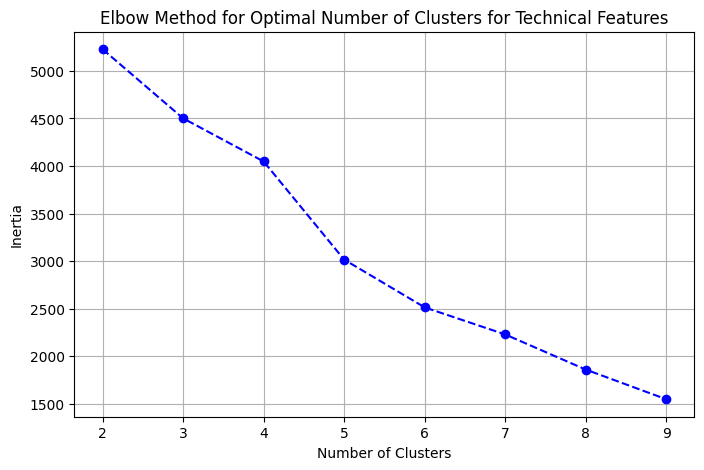

In [157]:
plt.figure(figsize=(8, 5))
plt.plot(cluster_range2, inertia_values2, marker='o', linestyle='--', color='b')
plt.title('Elbow Method for Optimal Number of Clusters for Technical Features')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [158]:
# Fit the final KMeans model with the selected number of clusters
optimal_k_technical = 5  # Choosen based on the elbow plot
kmeans_technical = KMeans(n_clusters=optimal_k, random_state=3101)
kmeans_technical.fit(features_technical)
subset_technical['Cluster_Labels'] = kmeans_technical.labels_

#Predict cluster labels for the original subset using the same KMeans model
subset_original2['Cluster_Labels'] = kmeans_technical.predict(features_original2)

In [159]:
# Calculate the distribution of PhoneService
phone_service_distribution = (
    subset_technical.groupby('Cluster_Labels')['PhoneService_Encoded']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

# Calculate the distribution of InternetService
internet_service_distribution = (
    subset_technical.groupby('Cluster_Labels')['InternetService_Encoded']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

# Calculate the distribution of TechSupport
tech_support_distribution = (
    subset_technical.groupby('Cluster_Labels')['TechSupport_Encoded']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

# Calculate the distribution of PaperlessBilling
paperless_billing_distribution = (
    subset_technical.groupby('Cluster_Labels')['PaperlessBilling_Encoded']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

# Calculate the distribution of PaymentMethod
payment_method_distribution = (
    subset_technical.groupby('Cluster_Labels')['PaymentMethod_Encoded']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

In [151]:
def generate_synthetic_features(df, distribution):
    synthetic_feature = []
    
    for _, row in df.iterrows():
        cluster = row['Cluster_Labels']
        
        # Sample a new feature based on the defined probabilities
        sample = np.random.choice(
            distribution.columns,  # Possible features to sample from
            p=distribution.loc[cluster].values  # Probabilities for the respective features
        )
        synthetic_feature.append(sample)
            
    return synthetic_feature

# Generate synthetic features
subset_original2['PhoneService'] = generate_synthetic_features(subset_original2, phone_service_distribution)
subset_original2['InternetService'] = generate_synthetic_features(subset_original2, internet_service_distribution)
subset_original2['TechSupport'] = generate_synthetic_features(subset_original2, tech_support_distribution)
subset_original2['PaperlessBilling'] = generate_synthetic_features(subset_original2, paperless_billing_distribution)
subset_original2['TechSupport'] = generate_synthetic_features(subset_original2, payment_method_distribution)

In [152]:
subset_original2.head()

,CLIENTNUM,Gender,Marital_Status,Attrition_Flag,SeniorCitizen,Dependents,Gender_Encoded,SeniorCitizen_Encoded,Marital_Status_Encoded,Dependents_Encoded,Attrition_Flag_Encoded,Cluster_Labels,PhoneService,InternetService,TechSupport,PaperlessBilling
0,768805383,M,Married,Existing Customer,0,Yes,1,0,1,1,1,1,1,0,2,0
1,818770008,F,Single,Existing Customer,0,Yes,0,0,2,1,1,2,1,1,3,0
2,713982108,M,Married,Existing Customer,0,Yes,1,0,1,1,1,1,1,1,3,0
4,709106358,M,Married,Existing Customer,0,Yes,1,0,1,1,1,1,1,1,2,1
5,713061558,M,Married,Existing Customer,0,Yes,1,0,1,1,1,1,1,2,0,1
